# Project Setup

Below are the instructions to run this Jupyter Notebook. 

**Step 1:** Set up the [CarND Term1 Starter Kit](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/83ec35ee-1e02-48a5-bdb7-d244bd47c2dc/lessons/8c82408b-a217-4d09-b81d-1bda4c6380ef/concepts/4f1870e0-3849-43e4-b670-12e6f2d4b7a7)

**Step 2:** Open Jupyter Notebook

* `> conda info --envs` , You should have set up the environment __carnd-term1__ as described in [CarND Term1 Starter Kit](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/83ec35ee-1e02-48a5-bdb7-d244bd47c2dc/lessons/8c82408b-a217-4d09-b81d-1bda4c6380ef/concepts/4f1870e0-3849-43e4-b670-12e6f2d4b7a7)
* __Windows__: `> activate carnd-term1` , __Mac__: `> source activate carnd-term1`
* `> jupyter notebook` , a browser window will appear showing the contents of the current directory.  Click on the file called __P1.ipynb__.  

**Step 3:** Execute this Jupyter Notebook


# Project: **Finding Lane Lines on the Road** 

Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  




<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Image without connecting/averaging/extrapolating line segments </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Goal: connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [5]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


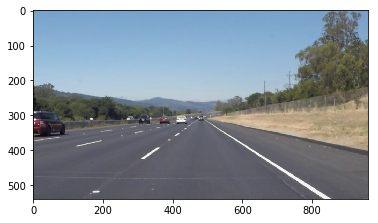

In [10]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


# check file system
import os
def check_fs():
    if not (os.path.exists("test_images_output") and os.path.isdir("test_images_output")):
        os.makedirs("test_images_output")
    if not (os.path.exists("test_videos_output") and os.path.isdir("test_videos_output")):
        os.makedirs("test_videos_output")

check_fs()

## Ideas for Lane Detection Pipeline

**OpenCV functions useful for this project:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

The pipeline consists of the following __main steps__ :

1. __Convert initial RGB image to to grayscale__. 
2. __Apply Gaussian smoothing__, before running Canny, which is essentially a way of suppressing noise and spurious gradients by averaging. A larger kernel_size implies averaging, or smoothing, over a larger area. The value used is tuned on tested videos and not automatically computed. 
3. __Perform Canny edge detection__. Thi algorithm will first detect strong edge (strong gradient) pixels above the high_threshold, and reject pixels below the low_threshold. Next, pixels with values between the low_threshold and high_threshold will be included as long as they are connected to strong edges. The output edges is a binary image with white pixels tracing out the detected edges and black everywhere else. Converting to grayscale has left us with an 8-bit image, so each pixel can take 2^8 = 256 possible values. Hence, the pixel values range from 0 to 255. This range implies that derivatives will be on the scale of tens or hundreds. So, a reasonable range for  threshold parameters would also be in the tens to hundreds.As far as a ratio of low_threshold to high_threshold, John Canny himself recommended a low to high ratio of 1:2 or 1:3. Here I'll use thresholds tuned on test videos. In case _contour conditions_ change, there is the possibility that such values need to recalibrated. An __auto-adaptive approach here would be useful__.   
4. __Define a region of interest and mask undesired portions of the image__. Here I'll use a quadrilateral whose vertices are tuned on test videos. In case the image height or width changes there is the possibility that such vertices need to be recalibrated. An __auto-adaptive approach here would be useful__.   
5. __Perform Hough transformation on Edge Detected Image__. Again, parameters such as distance and angular resolution of our grid in Hough space are tuned on test videos and not automatically computed. Also, we need to connect/average/extrapolate line segments (__draw_lines() __ function) in order to get "_desidered_" lane lines. I'll discuss my approach below.   
6. Finally, __apply detected lines to the original image__ as annotation.  

### draw_lines() function 

#### Extrapolation

In order to extrapolate lane lines, I will use the __polynomial of degree 1__ that is the __Least Squares Fit (P1-LSF)__ to the data. A possible __shortcoming__ can be the __linear assumption__ but will see that such assumption on test videos works. As possible improvement we could __compare the sum of the weighted squared errors__ of the __polynomial of degree 1__ and the __polynomial of degree 2__ that is the __Least Squares Fit__ to the data and choosing the best one.   

For further details, see [numpy.polynomial.polynomial.polyfit](https://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.polynomial.polynomial.polyfit.html) and [numpy.poly1d](https://docs.scipy.org/doc/numpy/reference/generated/numpy.poly1d.html#numpy.poly1d). 


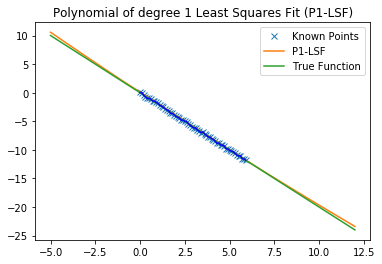

In [14]:
# data 
x = np.arange(0,6,0.1) 
x = x 
y = - 2 * x + np.random.normal(0, 0.1, x.shape[0])

# P1-LSF
z = np.polyfit(x, y, 2)
pd = np.poly1d(z)

# Extrapolation
xnew = np.array([-5,-4,-3,-2,-1,6,7,8,9,10,11,12])
ynew = pd(xnew)

# plot 
plt.plot(x, y, 'x', xnew, ynew, xnew, -2*xnew, x, y, 'b')
plt.legend(['Known Points', 'P1-LSF', 'True Function'])
plt.title('Polynomial of degree 1 Least Squares Fit (P1-LSF)')
plt.savefig('test_images_output/P1-LSF.png')
plt.show()

#### Interpolation

Same approach of extrapolation. 

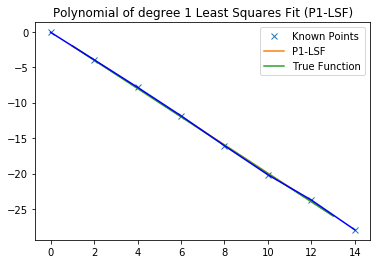

In [15]:
# data 
x = np.array([0,2,4,6,8,10,12,14])
x = x 
y = - 2 * x + np.random.normal(0, 0.1, x.shape[0])

# P1-LSF
z = np.polyfit(x, y, 2)
pd = np.poly1d(z)

# Extrapolation
xnew = np.array([1,3,5,7,9,11,13])
ynew = pd(xnew)

# plot 
plt.plot(x, y, 'x', xnew, ynew, xnew, -2*xnew, x, y, 'b')
plt.legend(['Known Points', 'P1-LSF', 'True Function'])
plt.title('Polynomial of degree 1 Least Squares Fit (P1-LSF)')
plt.savefig('test_images_output/P1-LSF_Intra.png')
plt.show()

## Helper Functions

In [16]:
import math
from scipy import interpolate

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=5,debug=False):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # divide 
    x_r , x_l, y_r, y_l = [] , [] , [] , []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope > 0:
                x_r.append(x1)
                x_r.append(x2)
                y_r.append(y1)
                y_r.append(y2)
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                if debug:
                    print("line:",line," >>>slope:",slope,">>right")
                    
            else:
                x_l.append(x1)
                x_l.append(x2)
                y_l.append(y1)
                y_l.append(y2)
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                if debug:
                    print("line:",line," >>>slope:",slope,">>left")
                    
    if len(x_l) == 0 or len(y_l) == 0 or len(x_r) == 0 or len(y_r) == 0:
        return 
                    
    
    # extrapolate 
    x_l_min = min(x_l)
    x_l_max = max(x_l)
    y_l_min = min(y_l)
    y_l_max = max(y_l)
    
    x_r_min = min(x_r)
    x_r_max = max(x_r)
    y_r_min = min(y_r)
    y_r_max = max(y_r)
    
    y_min = min(y_l_min,y_r_min)
    y_max = img.shape[0]
    
    if debug:
        print("x_l:",x_l)
        print("y_l:",y_l)
        print("x_r:",x_r)
        print("y_r:",y_r)
        print("y_min:",y_min)
        print("y_max:",y_max)
        
    
    # >>> l
    y_la = np.array(y_l)
    x_la = np.array(x_l)
    z = np.polyfit(y_la, x_la, 1)
    pd = np.poly1d(z)
    xnew = pd(np.array([y_min,y_max]))
    if debug:
        print("(int(xnew.tolist()[1]), y_max)",(int(xnew.tolist()[1]), y_max))
        print("(int(xnew.tolist()[0]), y_min)",(int(xnew.tolist()[0]), y_min))
    cv2.line(img, (x_l_max, y_l_min), (int(xnew.tolist()[0]), y_min), color, thickness)
    cv2.line(img, (x_l_min, y_l_max), (int(xnew.tolist()[1]), y_max), color, thickness)
    
    # filling holes
    y_new = np.arange(y_min,y_max,1)
    x_new = pd(y_new).tolist()
    for i, val in enumerate(x_new):
        cv2.line(img, (int(x_new[i]), int(y_new[i])), (int(x_new[i+1]), int(y_new[i+1])), color, thickness)
        if i >= len(x_new)/2:
            break
            
    # >>> r
    y_ra = np.array(y_r)
    x_ra = np.array(x_r)
    z = np.polyfit(y_ra, x_ra, 1)
    pd = np.poly1d(z)
    xnew = pd(np.array([y_min,y_max]))
    if debug:
        print("(int(xnew.tolist()[1]), y_max)",(int(xnew.tolist()[1]), y_max))
        print("(int(xnew.tolist()[0]), y_min)",(int(xnew.tolist()[0]), y_min))
    cv2.line(img, (x_r_min, y_r_min), (int(xnew.tolist()[0]), y_min), color, thickness)
    cv2.line(img, (x_r_max, y_r_max), (int(xnew.tolist()[1]), y_max), color, thickness)
    
    # filling holes 
    y_new = np.arange(y_min,y_max,1)
    x_new = pd(y_new).tolist()
    for i, val in enumerate(x_new):
        cv2.line(img, (int(x_new[i]), int(y_new[i])), (int(x_new[i+1]), int(y_new[i+1])), color, thickness)
        if i >= len(x_new)/2:
            break


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images


In [18]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory.

In [19]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

from scipy.misc import imsave


def find_lane_lines_internal(image,
                             vertices = np.array([[(80,image.shape[0]),(465, 315), (470, 300), (900,image.shape[0])]], dtype=np.int32)):
    image_cp = np.copy(image)
    gray = grayscale(img=image)

    # Define a kernel size and apply Gaussian smoothing
    blur_gray = gaussian_blur(gray, kernel_size=5)

    # Define our parameters for Canny and apply
    edges = canny(blur_gray, low_threshold=50, high_threshold=150)

    # Next we'll create a masked edges image using cv2.fillPoly()
    
    masked_edges = region_of_interest(edges,vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 5    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Draw the lines on the edge image
    return weighted_img(line_image, image_cp)

def find_lane_lines(input_dir,image_fn,output_dir='test_images_output'):
    # Read in and grayscale the image
    image = mpimg.imread(input_dir+'/'+image_fn)
    lines_edges = find_lane_lines_internal(image)
    plt.imshow(lines_edges)
    
    # Save edge image 
    if output_dir is not None:
        imsave(output_dir+'/'+image_fn,lines_edges)

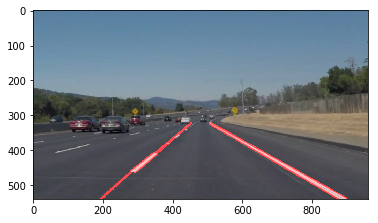

In [20]:
find_lane_lines('test_images','solidWhiteCurve.jpg')

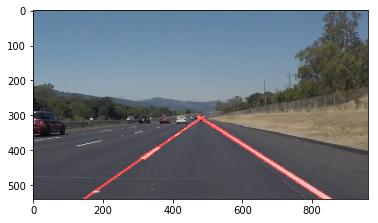

In [21]:
find_lane_lines('test_images','solidWhiteRight.jpg')

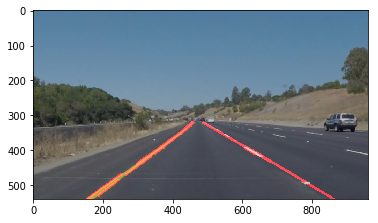

In [22]:
find_lane_lines('test_images','solidYellowCurve.jpg')

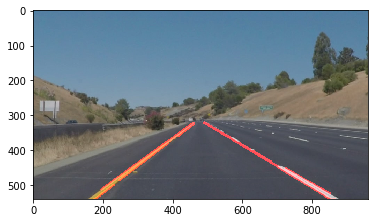

In [23]:
find_lane_lines('test_images','solidYellowCurve2.jpg')

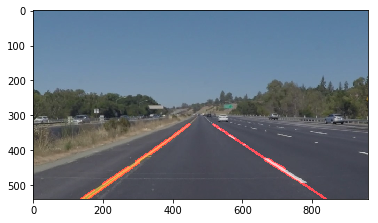

In [24]:
find_lane_lines('test_images','solidYellowLeft.jpg')

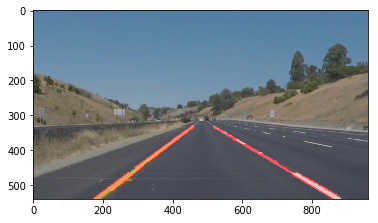

In [25]:
find_lane_lines('test_images','whiteCarLaneSwitch.jpg')

__Results are good, hence let's test on videos__

## Test on Videos

In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    return find_lane_lines_internal(image)

Let's try the one with the solid white lane on the right first ...

In [29]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 221/222 [00:06<00:00, 30.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 7.72 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

__Results are good, hence let's move on__

## The draw_lines() function

** The output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [31]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:23<00:00, 28.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 24.7 s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

__Results are still good except a couple of frames where on the left lane there was an horizontal white line perpendicular to the line lane__. In order to handle cases like this, a possibility can be performing clustering on slope for both left points and right points, i.e. __discarding points whose slope is too far from the centroids of the two main clusters__.       


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [18]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 16.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 16.9 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))